Epoch 1, Loss: 1.4008
Test Accuracy: 60.99%
Epoch 2, Loss: 0.9693
Test Accuracy: 69.96%
Epoch 3, Loss: 0.8024
Test Accuracy: 72.31%
Epoch 4, Loss: 0.6992
Test Accuracy: 74.31%
Epoch 5, Loss: 0.6132
Test Accuracy: 74.37%
Epoch 6, Loss: 0.5446
Test Accuracy: 75.51%
Epoch 7, Loss: 0.4832
Test Accuracy: 76.59%
Epoch 8, Loss: 0.4339
Test Accuracy: 76.98%
Epoch 9, Loss: 0.3880
Test Accuracy: 77.27%
Epoch 10, Loss: 0.3488
Test Accuracy: 76.57%
Epoch 11, Loss: 0.3128
Test Accuracy: 77.26%
Epoch 12, Loss: 0.2882
Test Accuracy: 77.13%
Epoch 13, Loss: 0.2689
Test Accuracy: 76.67%
Epoch 14, Loss: 0.2445
Test Accuracy: 76.90%
Epoch 15, Loss: 0.2343
Test Accuracy: 77.16%
Epoch 16, Loss: 0.2222
Test Accuracy: 77.07%
Epoch 17, Loss: 0.2103
Test Accuracy: 76.75%
Epoch 18, Loss: 0.1933
Test Accuracy: 76.39%
Epoch 19, Loss: 0.1880
Test Accuracy: 77.16%
Epoch 20, Loss: 0.1850
Test Accuracy: 77.20%


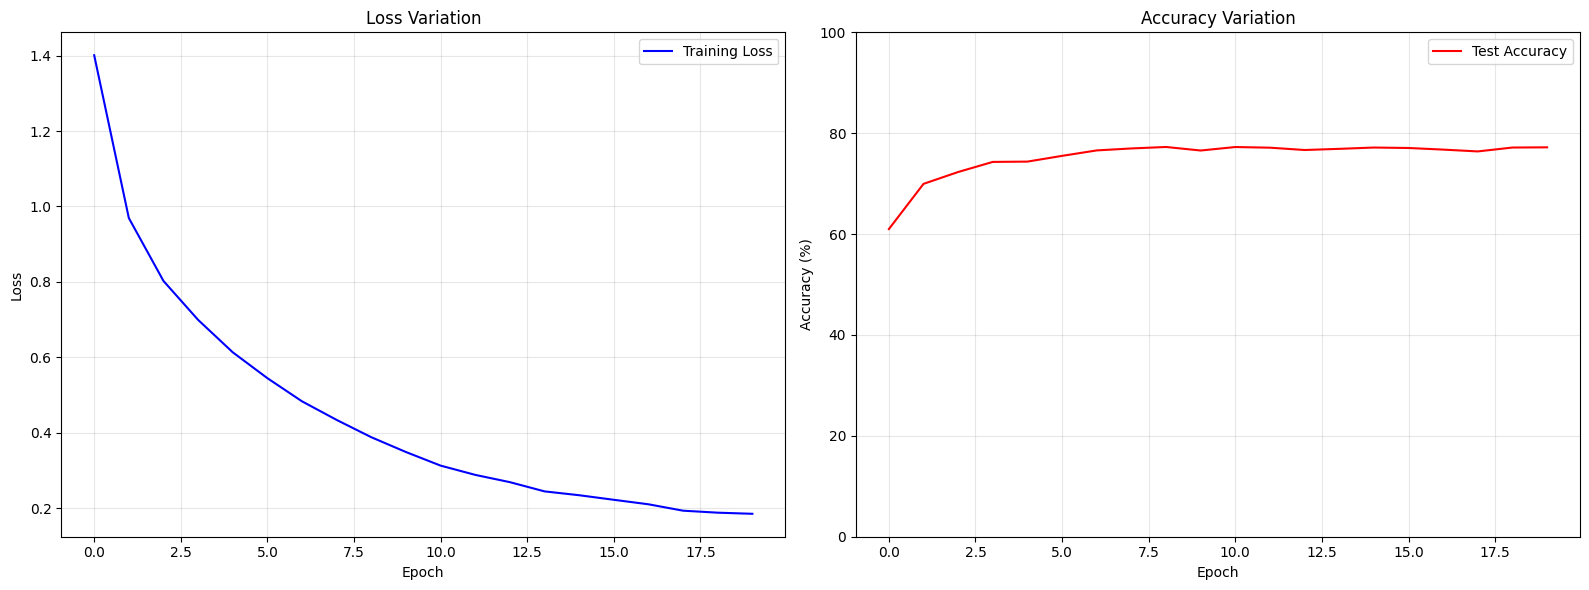

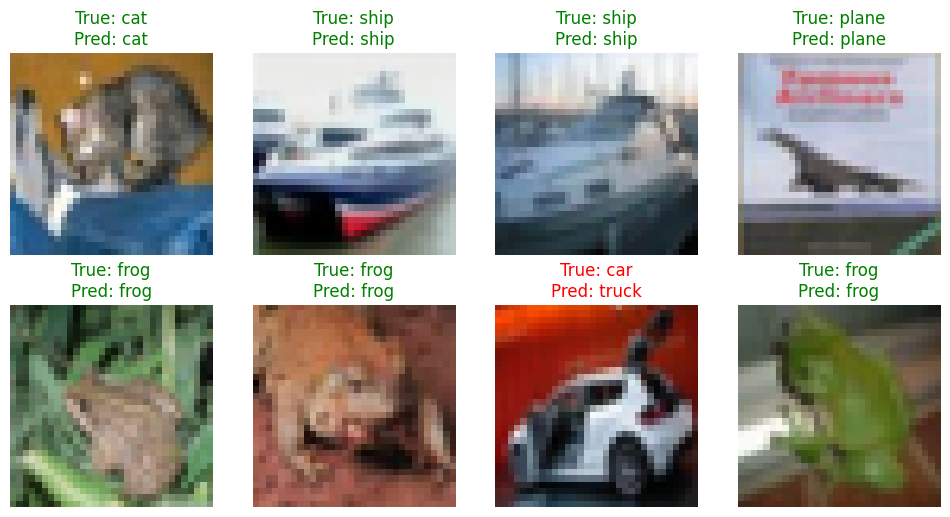

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

# 1. 数据预处理与加载
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))    # RGB通道的归一化参数
])

train_set = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)   # 训练集加载器 打乱以便每个epoch都能有不同的样本顺序
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)    # 测试集加载器

# 2. 构建VGG模型（简化版）
class SimpleVGG(nn.Module):
    def __init__(self):
        super(SimpleVGG, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1), # 卷积
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 池化
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(128 * 4 * 4, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# 3. 初始化模型、损失函数、优化器
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleVGG().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 4. 训练与验证
train_losses = []
test_accuracies = []

def train(epoch):
    model.train()
    running_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f'Epoch {epoch}, Loss: {avg_loss:.4f}')

def test():
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    acc = 100 * correct / total
    test_accuracies.append(acc)
    print(f'Test Accuracy: {acc:.2f}%')
    return acc

# 执行训练
for epoch in range(1, 21):
    train(epoch)
    test()

# 5. 训练日志可视化（Loss和准确率曲线并列展示）
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))  # 1行2列的子图布局

# 5.1 Loss变化曲线（左图）
ax1.plot(train_losses, label='Training Loss', color='blue')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Loss Variation')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 5.2 准确率变化曲线（右图）
ax2.plot(test_accuracies, label='Test Accuracy', color='red')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Accuracy Variation')
ax2.set_ylim(0, 100)  # 准确率范围固定在0-100%
ax2.legend()
ax2.grid(True, alpha=0.3)

# 调整子图间距，避免标题重叠
plt.tight_layout()
plt.show()

# 6. 分类结果可视化
def plot_predictions():
    model.eval()
    dataiter = iter(test_loader)
    images, labels = next(dataiter)
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)
    
    # 类别名称
    classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    
    # 绘制图片
    plt.figure(figsize=(12, 6))
    for i in range(8):
        plt.subplot(2, 4, i+1)
        img = images[i].cpu().numpy().transpose((1, 2, 0))
        mean = np.array([0.4914, 0.4822, 0.4465])
        std = np.array([0.2023, 0.1994, 0.2010])
        img = std * img + mean
        img = np.clip(img, 0, 1)
        plt.imshow(img)
        plt.title(f'True: {classes[labels[i]]}\nPred: {classes[predicted[i]]}', 
                  color='green' if predicted[i]==labels[i] else 'red')
        plt.axis('off')
    plt.show()

plot_predictions()